# Factor Models
## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. **Decode the α / β decomposition** — Split any asset's excess return into factor-driven and idiosyncratic pieces
2. **Estimate factor exposure with regression** — Use OLS to obtain α, β, and residual statistics
3. **Create tracking and hedged portfolios** — Build factor-neutral "portable alpha" positions
4. **Apply risk budgets to position sizing** — Determine capital allocation under volatility constraints
5. **Evaluate performance with Sharpe and Appraisal ratios** — Distinguish skill from factor exposure

## 📋 Table of Contents

1. [Setup](#setup)
2. [Towards a Factor Model](#towards-a-factor-model)
3. [Risk Models vs Expected Return Models](#risk-vs-expected-return)
4. [Alpha and Beta: The Organization of Wall Street](#alpha-beta)
5. [Tracking and Hedged Portfolios](#tracking-hedging)
6. [Risk Budgets and Position Sizing](#risk-budgets)
7. [Sharpe Ratio and Appraisal Ratio](#performance-metrics)
8. [Variance Decomposition](#variance-decomposition)
9. [Exercises](#exercises)
10. [Key Takeaways](#key-takeaways)

---

## 🛠️ Setup <a id="setup"></a>

In [ ]:
#@title 🛠️ Setup: Run this cell first (click to expand)

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



# Set consistent plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [ ]:
#@title Helper Function: Get Factor Data
# pandas-datareader: Fetches financial data from various online sources
# We'll use it to get Fama-French factor data from Ken French's website
import datetime
from pandas_datareader.data import DataReader
def get_factors(factors='CAPM', freq='daily'):
    """Download Fama-French factor data.
    
    Parameters:
    - factors: 'CAPM', 'FF3', 'FF5', or 'FF6'
    - freq: 'daily' or 'monthly'
    
    Returns: DataFrame with factor returns (as decimals)
    """
    freq_label = '' if freq == 'monthly' else '_' + freq
    
    if factors == 'CAPM':
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF']]
    elif factors == 'FF3':
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
    elif factors == 'FF5':
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
        ff2 = DataReader(f"F-F_Research_Data_5_Factors_2x3{freq_label}", "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff2[0][['RMW', 'CMA']], on='Date', how='outer')
    else:  # FF6
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
        ff2 = DataReader(f"F-F_Research_Data_5_Factors_2x3{freq_label}", "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff2[0][['RMW', 'CMA']], on='Date', how='outer')
        ff_mom = DataReader(f"F-F_Momentum_Factor{freq_label}", "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff_mom[0], on='Date')
        df_factor.columns = ['RF', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
    
    if freq == 'monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp()) + pd.offsets.MonthEnd(0)
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
    return df_factor / 100  # Convert from percent to decimal

---

## Towards a Factor Model <a id="towards-a-factor-model"></a>

### The Core Insight

Stocks don't move independently—they co-move with the market.

But the **degree of co-movement varies**:
- **Defensive stocks** (utilities, groceries) → less sensitive to market swings
- **Cyclical stocks** (luxury goods, banks) → more sensitive to market swings
- **High-leverage stocks** → particularly vulnerable in downturns

### The Factor Model Equation

We decompose any asset's excess return as:

$$r^e = \alpha + \beta \cdot f + \epsilon$$

Where:
- $r^e$ = asset's excess return over risk-free rate
- $\alpha$ = intercept (skill/mispricing)
- $\beta$ = sensitivity to factor
- $f$ = factor excess return (e.g., market)
- $\epsilon$ = idiosyncratic (asset-specific) risk

> **💡 Key Insight:**
>
> This decomposition is always valid—it's just statistics.
> The power comes from *interpreting* each piece:
> - $\beta \cdot f$ is the return you could get by investing in the factor in a way that tracks the asset as well as possible
> - $\alpha+\epsilon$ is the return specific to the asset only. Alpha is the mean. Epsilon is the noise.

### Loading Return Data

In [4]:
# Load excess returns for SPY, WMT, JPM
url = 'https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/FactorModels_data1.csv'
df_re = pd.read_csv(url, parse_dates=['date'], index_col='date')

print(f"Data range: {df_re.index.min().date()} to {df_re.index.max().date()}")
print(f"Stocks: {list(df_re.columns)}")
df_re.tail()

Data range: 1969-03-05 to 2024-12-31
Stocks: ['SPY', 'WMT', 'JPM']


,SPY,WMT,JPM
date,,,
2024-12-24,0.010940,0.025614,0.016269
2024-12-26,-0.000106,0.001014,0.003252
2024-12-27,-0.010698,-0.012349,-0.008273
2024-12-30,-0.011585,-0.012065,-0.007844
2024-12-31,-0.003811,-0.002602,0.001457


> **🤔 Think and Code:**
>
> 1. How do we estimate $\beta$ and $\alpha$ from data?
> 2. What should we plot to visualize if the factor model "works"?
> 3. What do you expect the correlation between residuals and factor to be?

### Estimating Beta with Regression

In [6]:
# statsmodels: Statistical modeling library for Python
# Provides OLS regression, hypothesis testing, and model diagnostics

import statsmodels.formula.api as smf

# Prepare data (drop missing values)
data = df_re.dropna(subset=['SPY', 'WMT', 'JPM'])

# Run regressions for WMT and JPM on SPY
model_wmt = smf.ols(formula='WMT ~ SPY', data=data).fit()
model_jpm = smf.ols(formula='JPM ~ SPY', data=data).fit()

alpha_wmt, beta_wmt = model_wmt.params
alpha_jpm, beta_jpm = model_jpm.params

print(f"WMT: α = {alpha_wmt:.6f}, β = {beta_wmt:.3f}")
print(f"JPM: α = {alpha_jpm:.6f}, β = {beta_jpm:.3f}")

WMT: α = 0.000203, β = 0.674
JPM: α = 0.000159, β = 1.395


> **📌 Remember:**
>
> - $\beta < 1$: Less sensitive than market (defensive)
> - $\beta = 1$: Same sensitivity as market
> - $\beta > 1$: More sensitive than market (aggressive)

### Visualizing Co-movement

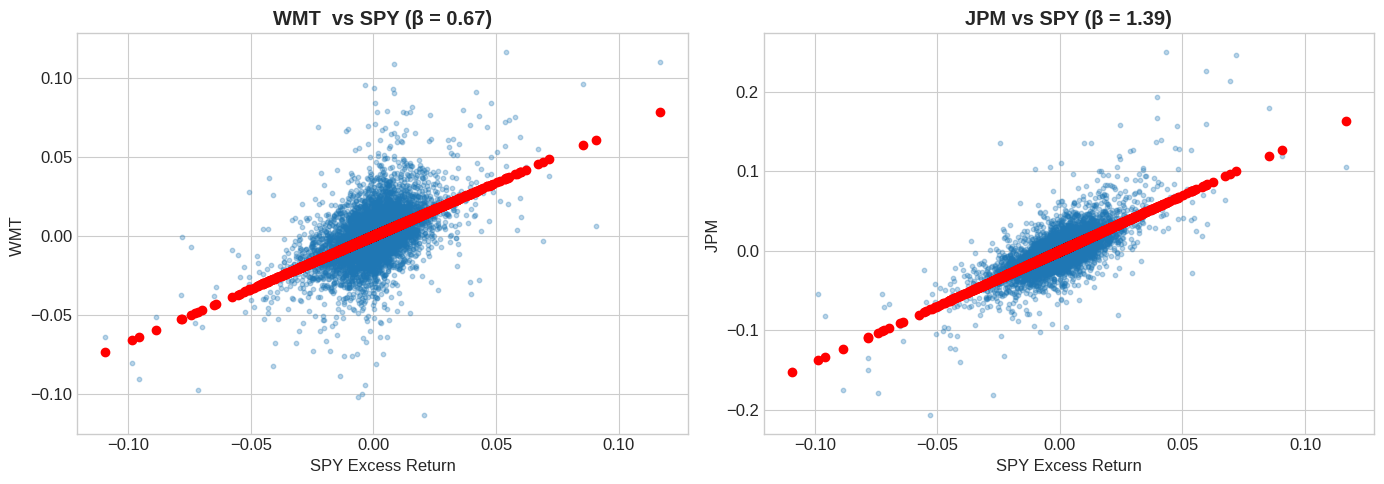

Correlation of SPY with WMT : 0.492221
Correlation of SPY with JPM: 0.707302


In [14]:
# Create residuals
wmt = data['WMT']
jpm = data['JPM']

# Plot residuals vs factor
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(data['SPY'], wmt, alpha=0.3, s=10)
axes[0].scatter(data['SPY'],alpha_wmt+beta_wmt * data['SPY'], color='red', linestyle='-')
axes[0].set_xlabel('SPY Excess Return')
axes[0].set_ylabel('WMT ')
axes[0].set_title(f'WMT  vs SPY (β = {beta_wmt:.2f})', fontweight='bold')

axes[1].scatter(data['SPY'], jpm, alpha=0.3, s=10)
axes[1].scatter(data['SPY'],alpha_jpm+beta_jpm * data['SPY'], color='red', linestyle='-')
axes[1].set_xlabel('SPY Excess Return')
axes[1].set_ylabel('JPM ')
axes[1].set_title(f'JPM vs SPY (β = {beta_jpm:.2f})', fontweight='bold')

plt.tight_layout()
plt.show()

# Verify residuals are uncorrelated with factor
print(f"Correlation of SPY with WMT : {data['SPY'].corr(wmt):.6f}")
print(f"Correlation of SPY with JPM: {data['SPY'].corr(jpm):.6f}")

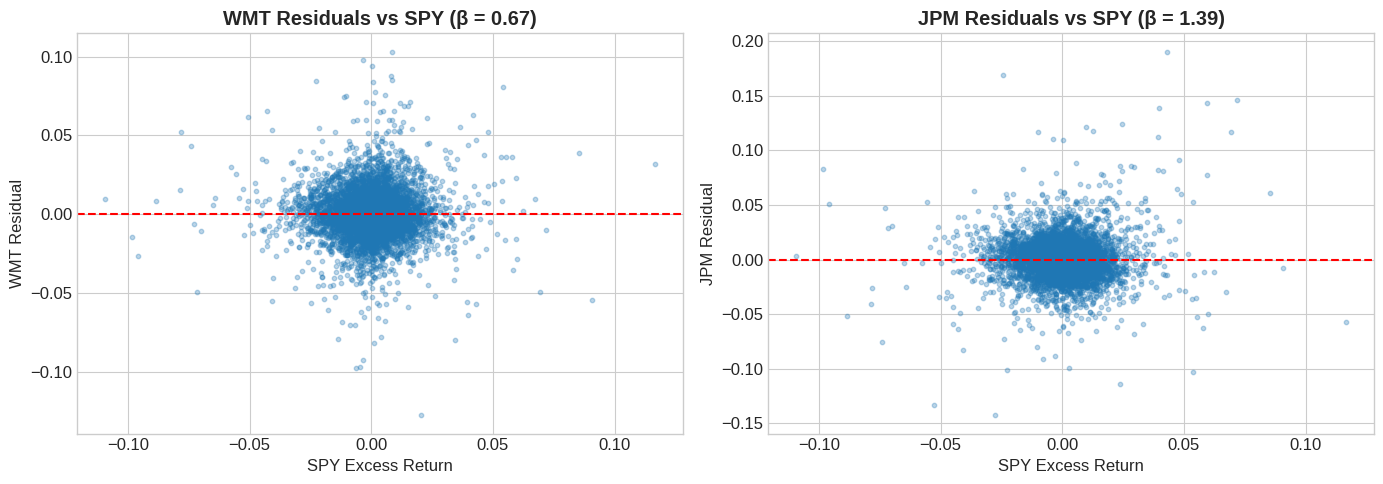

Correlation of SPY with WMT residuals: 0.000000
Correlation of SPY with JPM residuals: 0.000000


In [8]:
# Create residuals
resid_wmt = data['WMT'] - beta_wmt * data['SPY']
resid_jpm = data['JPM'] - beta_jpm * data['SPY']

# Plot residuals vs factor
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(data['SPY'], resid_wmt, alpha=0.3, s=10)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('SPY Excess Return')
axes[0].set_ylabel('WMT Residual')
axes[0].set_title(f'WMT Residuals vs SPY (β = {beta_wmt:.2f})', fontweight='bold')

axes[1].scatter(data['SPY'], resid_jpm, alpha=0.3, s=10)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('SPY Excess Return')
axes[1].set_ylabel('JPM Residual')
axes[1].set_title(f'JPM Residuals vs SPY (β = {beta_jpm:.2f})', fontweight='bold')

plt.tight_layout()
plt.show()

# Verify residuals are uncorrelated with factor
print(f"Correlation of SPY with WMT residuals: {data['SPY'].corr(resid_wmt):.6f}")
print(f"Correlation of SPY with JPM residuals: {data['SPY'].corr(resid_jpm):.6f}")

---

## Risk Models vs Expected Return Models <a id="risk-vs-expected-return"></a>

Factor models serve two distinct purposes:

### 👉 Risk Models

- Goal: Explain **realized return variation**
- Assumption: $\epsilon$ is uncorrelated across assets
- Key metric: **R-squared** (how much variance is explained?)
- Can it explain realized returns?
- Use case: Risk management, covariance estimation

### 👉 Expected Return Models

- Goal: Explain **expected return differences**
- Assumption: $\alpha = 0$ for all assets
- Key metric: **Alpha** (is it close to zero?)
- can it explain differences in Average returns  across assets and strategies as a function of factor loadings (i.e. betas?)
- Use case: Performance evaluation, asset pricing tests

> **💡 Key Insight:**
>
> A model can be great for risk but poor for expected returns.
> For stocks, factor models explain lots of variance but still leave
> substantial uncertainty about expected returns.

---

## Alpha and Beta: The Organization of Wall Street <a id="alpha-beta"></a>

### How the Industry is Organized

The $\alpha$- $\beta$ decomposition is how Wall Street operates:

- **Big bonuses** only come from perceied $\alpha$ (skill)
- **Beta exposure** is close to a commodity—exact commodity for  market exposure, closer to commodity for other factors
- **Pod shops** require traders to be factor-neutral (not only market but across many factors):
  - [Citadel](https://www.wsj.com/finance/investing/citadel-ken-griffin-hedge-funds-c9ddf51d)
  - [Millennium](https://www.wsj.com/finance/investing-the-giant-hedge-fund-that-hates-risk-and-still-wins-1110e90a)
  - [Balyasny](https://www.bamfunds.com/)

### From Factor Exposure to Expected Returns

Taking expectations of our factor model:

$$E[r] = r_f + \alpha + \beta \cdot E[f]$$

Expected return decomposes into:
- $r_f$: Risk-free rate (time value of money)
- $\beta \cdot E[f]$: Premium from factor exposure
- $\alpha$: Abnormal return (skill or mispricing)

> **⚠️ Caution:**
>
> If you have a good model of expected returns, $\alpha$ should be zero.
> A significant $\alpha$ means either:
> 1. You found skill/mispricing, OR
> 2. Your factor model is missing something

- So it is all about interepretation.

- In the industry, a trader often takes the factor model as given and try to beat it

- The factor model can come from clients or the central book.

- If you are a family office, managing money for a sovereign wealth fund, or giving advice to a client it will be your job to determine what factors to include


---

## Tracking and Hedged Portfolios <a id="tracking-hedging"></a>

### Loading MSFT Data for Hedging Example

In [15]:
# Load MSFT returns
url_msft = 'https://raw.githubusercontent.com/amoreira2/UG54/refs/heads/main/assets/data/FactorModels_data2.csv'
df_returns = pd.read_csv(url_msft, parse_dates=['date'], index_col='date')

# Get factor data
df_factor = get_factors()

# Align the two DataFrames on common dates
df_returns, df_factor = df_returns.dropna().align(df_factor.dropna(), join='inner', axis=0)

print(f"Data range: {df_returns.index.min().date()} to {df_returns.index.max().date()}")
print(f"Observations: {len(df_returns)}")

Data range: 1986-03-14 to 2024-12-31
Observations: 9778


### Running the Factor Regression

In [17]:
import statsmodels.api as sm

# Compute MSFT excess returns
df_eret = df_returns['MSFT'] - df_factor['RF']

# Prepare regression
X = sm.add_constant(df_factor['Mkt-RF'])  # Add intercept
y = df_eret

# Fit OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     6940.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        20:45:46   Log-Likelihood:                 26516.
No. Observations:                9778   AIC:                        -5.303e+04
Df Residuals:                    9776   BIC:                        -5.301e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.597      0.0

In [19]:
# Extract key statistics
alpha = model.params['const']
beta = model.params['Mkt-RF']
var_r = y.var()
var_f = df_factor['Mkt-RF'].var()
var_e = model.resid.var()
mu_f = df_factor['Mkt-RF'].mean()

print(f"Alpha :     {alpha:.6f}")
print(f"Beta:              {beta:.3f}")
print(f"Variance of MSFT:  {var_r:.6f}")
print(f"Variance of MKT:   {var_f:.6f}")
print(f"Variance of resid: {var_e:.6f}")
print(f"Mean MKT excess:   {mu_f:.6f}")

Alpha :     0.000585
Beta:              1.188
Variance of MSFT:  0.000442
Variance of MKT:   0.000130
Variance of resid: 0.000258
Mean MKT excess:   0.000359


> **🤔 Think and Code:**
>
> - Is this alpha economically significant?
> - What shoudl I do to have a sense of it?
> - IS it a good bet on a risk-reward sense? What should I look at?


### The Tracking Portfolio (also called mimicking portfolio, factor-mimicking portfolio or Hedging Portfolio)

The **tracking portfolio** replicates the factor-driven component:

$$\text{Tracking Return} = \beta \times f$$

For MSFT with $\beta \approx 1.2$:
- For every 1 dollar in MSFT, hold  $\beta$ dollars in the market factor

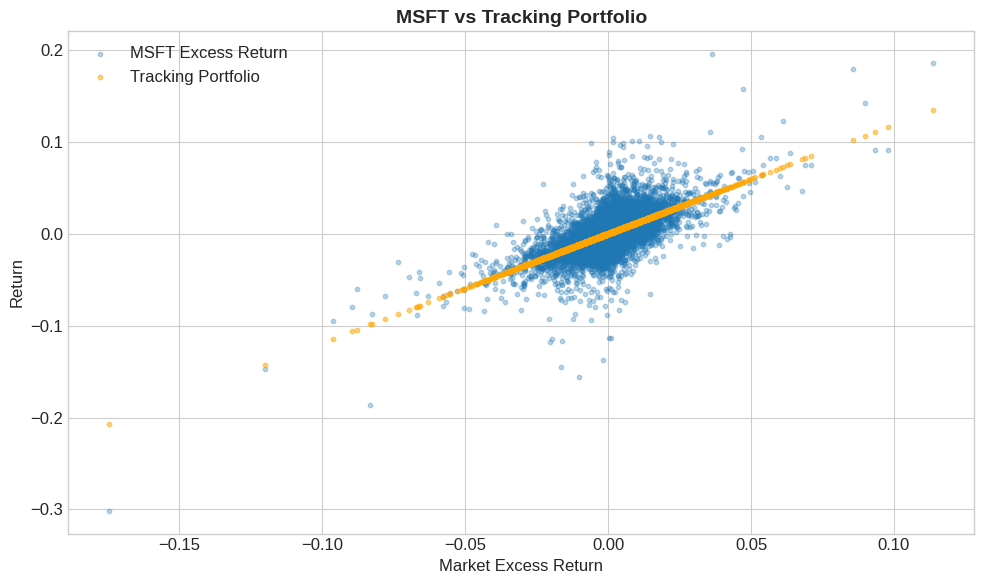

In [20]:
# Compute tracking portfolio returns
MKT = df_factor['Mkt-RF']
Portfolio = df_eret
Tracking = MKT * beta

# Plot actual vs tracking
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(MKT, Portfolio, alpha=0.3, s=10, label='MSFT Excess Return')
ax.scatter(MKT, Tracking, alpha=0.5, s=10, label='Tracking Portfolio', color='orange')
ax.set_xlabel('Market Excess Return')
ax.set_ylabel('Return')
ax.set_title('MSFT vs Tracking Portfolio', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

### The Hedged Portfolio

The **hedged portfolio** removes all factor exposure:

$$r^{\text{hedged}} = r^e - \beta \cdot f = \alpha + \epsilon$$

Properties:
- Mean return = $\alpha$ (pure skill)
- Volatility = $\sigma_{\epsilon}$ (only idiosyncratic risk), often that is the compoentn that people call Tracking error
- Beta = 0 (by construction, we already stripped out all factor exposure!)

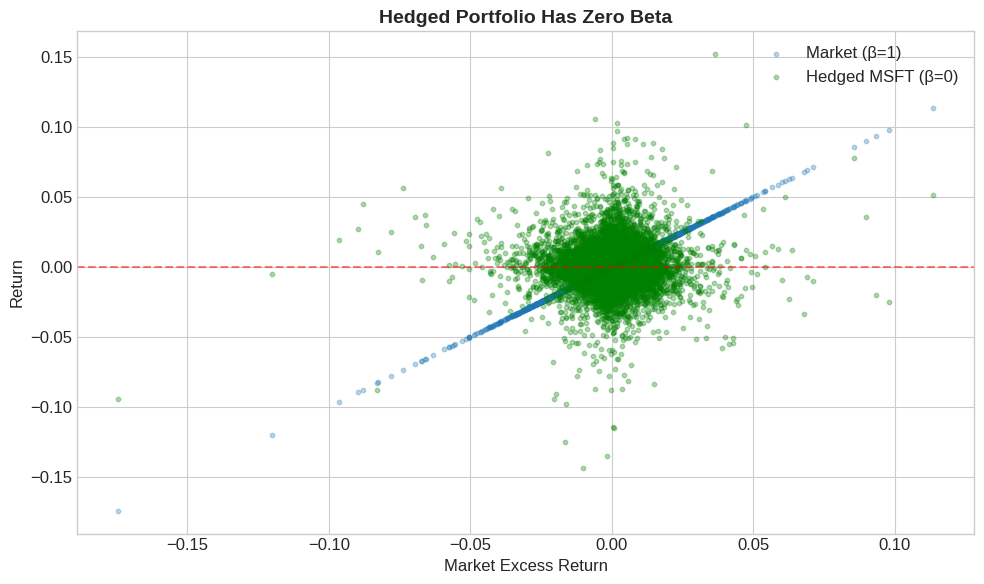

Hedged portfolio mean (annualized): 0.1474
Alpha (annualized):                 0.1474


In [21]:
# Compute hedged portfolio
Hedged = Portfolio - Tracking

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(MKT, MKT, alpha=0.3, s=10, label='Market (β=1)')
ax.scatter(MKT, Hedged, alpha=0.3, s=10, label='Hedged MSFT (β=0)', color='green')
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Market Excess Return')
ax.set_ylabel('Return')
ax.set_title('Hedged Portfolio Has Zero Beta', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Verify
print(f"Hedged portfolio mean (annualized): {Hedged.mean() * 252:.4f}")
print(f"Alpha (annualized):                 {alpha * 252:.4f}")

---

## Risk Budgets and Position Sizing <a id="risk-budgets"></a>

### Position Sizing Under a Volatility Budget

Suppose you have a **$1 million/month volatility budget**.

How much MSFT can you buy?

What is the math?

In [22]:
# Monthly volatility of MSFT
vol_monthly = np.sqrt(var_r) * np.sqrt(21)  # ~21 trading days per month

# Volatility budget
budget = 1_000_000  # $1M

# Position size
x = ____

print(f"MSFT monthly volatility: {vol_monthly:.4f}")
print(f"Position size: ${x:,.0f}")

MSFT monthly volatility: 0.0963
Position size: $10,383,575


### Expected P&L

Your expected P&L has two components:
- **Total**: $x \times (\beta \cdot \mu_f + \alpha) \times 252$
- **Risk-adjusted**: $x \times \alpha \times 252$ (what you get paid for)

In [23]:
print(f"Expected annual P&L (total):         ${x * (beta * mu_f + alpha) * 252:,.0f}")
print(f"Expected annual P&L (risk-adjusted): ${x * alpha * 252:,.0f}")

Expected annual P&L (total):         $2,644,594
Expected annual P&L (risk-adjusted): $1,530,371


### Hedging Allows Larger Positions

With hedging, volatility = $\sigma_\epsilon$ (smaller than $\sigma_r$).

You can take a **larger position** for the same risk budget!

In [25]:
# Hedged volatility (annual)
vol_hedged_annual = np.sqrt(var_e) * np.sqrt(21)

# Annual budget
budget_annual = 1_000_000

# Hedged position size
xe = budget_annual / vol_hedged_annual

print(f"Unhedged vol (annual): {np.sqrt(var_r) * np.sqrt(252):.4f}")
print(f"Hedged vol (annual):   {vol_hedged_annual:.4f}")
print(f"\nUnhedged position: ${x:,.0f}")
print(f"Hedged position:   ${xe:,.0f}")
print(f"\nHedged P&L:        ${xe * alpha * 252:,.0f}")

Unhedged vol (annual): 0.3336
Hedged vol (annual):   0.0736

Unhedged position: $10,383,575
Hedged position:   $13,578,071

Hedged P&L:        $2,001,189


> **💡 Key Insight:**
>
> Hedging reduces volatility, which allows larger position sizes.
> If your alpha is genuine, hedging lets you earn more of it!

---

## Sharpe Ratio and Appraisal Ratio <a id="performance-metrics"></a>

### Sharpe Ratio

Measures excess return per unit of **total** risk:

$$\text{Sharpe} = \frac{E[r^e]}{\sigma(r^e)}$$

In [26]:
# Sharpe ratios (annualized)
sharpe_unhedged = (df_eret.mean() * 252) / (df_eret.std() * np.sqrt(252))
sharpe_hedged = (Hedged.mean() * 252) / (Hedged.std() * np.sqrt(252))

print(f"Sharpe Ratio (unhedged): {sharpe_unhedged:.3f}")
print(f"Sharpe Ratio (hedged):   {sharpe_hedged:.3f}")

Sharpe Ratio (unhedged): 0.763
Sharpe Ratio (hedged):   0.578


### Appraisal Ratio

Measures **alpha** per unit of **idiosyncratic** risk:

$$\text{Appraisal Ratio} = \frac{\alpha}{\sigma(\epsilon)}$$

This is the Sharpe ratio of the hedged portfolio—the "true" skill measure.

In [27]:
# Appraisal ratio (annualized)
appraisal = (alpha * 252) / (np.sqrt(var_e) * np.sqrt(252))

print(f"Appraisal Ratio: {appraisal:.3f}")

Appraisal Ratio: 0.578


> **⚠️ Caution:**
>
> Hedging doesn't always improve your Sharpe ratio!
> If the factor has a high premium and your alpha is small,
> you might be better off keeping the factor exposure.

> But of course--exposure to factors are fundamentally different then expsoure to $\epsilon$. Why?

---

## Variance Decomposition <a id="variance-decomposition"></a>

### Breaking Down Total Risk

Total variance decomposes into factor and idiosyncratic parts:

$$\text{Var}(r^e) = \beta^2 \cdot \text{Var}(f) + \text{Var}(\epsilon)$$

The **factor risk share** is:

$$\frac{\beta^2 \cdot \text{Var}(f)}{\text{Var}(r^e)}$$

In [28]:
# Variance decomposition
factor_var = beta**2 * var_f
idio_var = var_e
total_var = var_r

factor_share = factor_var / total_var
idio_share = idio_var / total_var

print(f"Factor variance contribution: {factor_var:.6f} ({factor_share:.1%})")
print(f"Idiosyncratic variance:       {idio_var:.6f} ({idio_share:.1%})")
print(f"Total variance:               {total_var:.6f}")

# This should equal R-squared
print(f"\nR-squared from regression: {model.rsquared:.3f}")
print(f"Factor share:              {factor_share:.3f}")

Factor variance contribution: 0.000183 (41.5%)
Idiosyncratic variance:       0.000258 (58.5%)
Total variance:               0.000442

R-squared from regression: 0.415
Factor share:              0.415


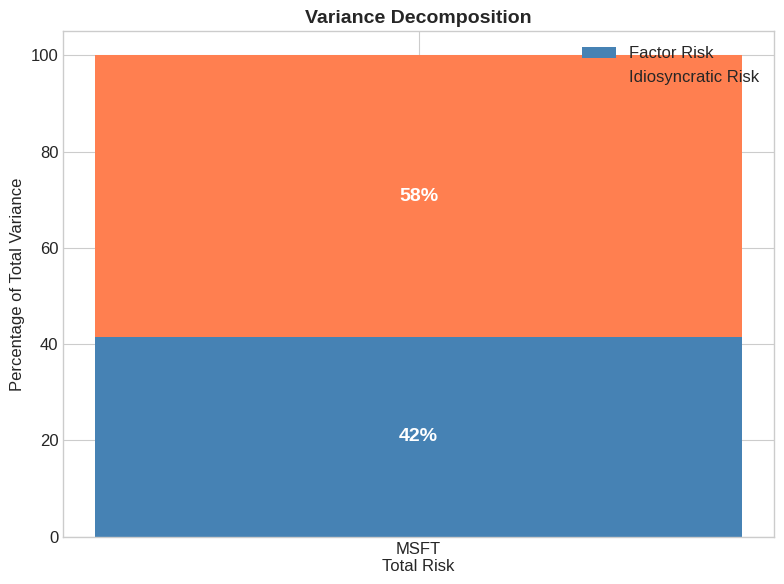

In [29]:
# Visualize variance decomposition
fig, ax = plt.subplots(figsize=(8, 6))

categories = ['MSFT\nTotal Risk']
factor_vals = [factor_share * 100]
idio_vals = [idio_share * 100]

ax.bar(categories, factor_vals, label='Factor Risk', color='steelblue')
ax.bar(categories, idio_vals, bottom=factor_vals, label='Idiosyncratic Risk', color='coral')

ax.set_ylabel('Percentage of Total Variance')
ax.set_title('Variance Decomposition', fontsize=14, fontweight='bold')
ax.legend()
ax.set_ylim(0, 105)

# Add percentage labels
ax.text(0, factor_share * 50, f'{factor_share:.0%}', ha='center', va='center',
        fontsize=14, fontweight='bold', color='white')
ax.text(0, factor_share * 100 + idio_share * 50, f'{idio_share:.0%}', ha='center',
        va='center', fontsize=14, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

---

## Exercises <a id="exercises"></a>

### 🔧 Exercise 1: Estimate Factor Model for JPM

Using the `df_re` DataFrame loaded earlier:

1. Run a regression of JPM excess returns on SPY
2. Report the $\alpha$, $\beta$, and R-squared
3. Is JPM more or less sensitive to the market than WMT?

<details>
<summary>💡 Click for solution</summary>

```python
import statsmodels.api as sm

# Prepare data
data = df_re.dropna()
X = sm.add_constant(data['SPY'])
y = data['JPM']

# Fit model
model_jpm = sm.OLS(y, X).fit()

print(f"Alpha: {model_jpm.params['const']:.6f}")
print(f"Beta: {model_jpm.params['SPY']:.3f}")
print(f"R-squared: {model_jpm.rsquared:.3f}")
```

JPM has a higher beta than WMT, making it more sensitive to market movements.

</details>

In [ ]:
# Your code here

### 🔧 Exercise 2: Build a Hedged Portfolio

Using your JPM regression results:

1. Compute the hedged portfolio returns: $r^{\text{hedged}} = r^e_{JPM} - \beta \times r^e_{SPY}$
2. Verify that the hedged portfolio has zero correlation with SPY
3. Calculate the Sharpe ratio of the hedged vs unhedged portfolio

<details>
<summary>💡 Click for solution</summary>

```python
beta_jpm = model_jpm.params['SPY']

# Hedged portfolio
hedged_jpm = data['JPM'] - beta_jpm * data['SPY']

# Verify zero correlation
print(f"Correlation with SPY: {data['SPY'].corr(hedged_jpm):.6f}")

# Sharpe ratios
sharpe_unhedged = (data['JPM'].mean() * 252) / (data['JPM'].std() * np.sqrt(252))
sharpe_hedged = (hedged_jpm.mean() * 252) / (hedged_jpm.std() * np.sqrt(252))

print(f"Sharpe (unhedged): {sharpe_unhedged:.3f}")
print(f"Sharpe (hedged): {sharpe_hedged:.3f}")
```

</details>

In [ ]:
# Your code here

### 🤔 Exercise 3: Position Sizing Challenge

You have a $5 million annual volatility budget.

1. How much can you invest in JPM (unhedged)?
2. How much can you invest in the hedged JPM strategy?
3. What is the expected risk-adjusted P&L for each?

<details>
<summary>💡 Click for solution</summary>

```python
budget = 5_000_000

# Volatilities
vol_jpm = data['JPM'].std() * np.sqrt(252)
vol_hedged = hedged_jpm.std() * np.sqrt(252)

# Position sizes
pos_unhedged = budget / vol_jpm
pos_hedged = budget / vol_hedged

print(f"Unhedged position: ${pos_unhedged:,.0f}")
print(f"Hedged position:   ${pos_hedged:,.0f}")

# Risk-adjusted P&L (alpha only)
alpha_jpm = model_jpm.params['const']
pnl_unhedged = pos_unhedged * alpha_jpm * 252
pnl_hedged = pos_hedged * alpha_jpm * 252

print(f"\nRisk-adjusted P&L (unhedged): ${pnl_unhedged:,.0f}")
print(f"Risk-adjusted P&L (hedged):   ${pnl_hedged:,.0f}")
```

</details>

In [ ]:
# Your code here

---

## 📝 Key Takeaways <a id="key-takeaways"></a>

- **Factor models separate what you earn from what you ride.** Beta captures common market movements; alpha is the slice of return not explained by those movements.

- **Hedging out β turns views into "portable" alpha.** Going long the asset and short β units of the factor neutralizes systematic risk.

- **Risk budgets shrink once you hedge intelligently.** A hedged position's lower volatility allows you to deploy more capital for the same risk cap.

- **Variance decomposition is your monitoring dashboard.** It tells you how much of today's risk is coming from factors versus idiosyncratic shocks.

- **Tracking portfolios clarify performance attribution.** By explicitly matching the factor component, you can assess whether outperformance is genuine skill or hidden beta.

- **All numbers are frequency-specific.** Alpha, variances, and Sharpe ratios must be annualized consistently. Beta is theoretically invariant to frequency.